<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI/blob/master/3_DeepLearning/09_pyTorch%EB%A5%BC%20%EC%9D%B4%EC%9A%A9%ED%95%9C%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 개요


- CNN에 대한 이해도가 60% 정도?
- 합성곱층, 풀링층을 간단하게라도 직접 행렬연산을 통해서 구현해본다.
- 이미 만들어져 있는 API도 사용하여 비교
- W, b에 대한 의미를 명확하게 이해
- 공용 파라미터로 가중치를 가지는 필터(커널)를 직접 만들어서 사용(수직 필터, 수평 필터를 사용할 것 => 둘을 결합하면 외곽선 디텍팅을 위한 선명한 외곽선 정보를 얻을 수 있다.)
- x, W, s, p 등 관계식도 확인

In [ ]:
import torch

In [ ]:
torch.__version__

'1.6.0+cu101'

# CNN의 기본 원리

- 시각 피질 작동 원리 이해
- 이론 : 1950년대 등장
  - 시각 인지 과정
    - 눈에서 사물을 인식하는 방식은 계층적으로 진행된다.
    - 눈 안에 있는 여러 세포들이 각각의 역할을 가지고 존재한다.
    - 눈 앞에 있는 사물에 대해서는 일부의 세포만이 인지한다.
    - 눈 앞쪽의 세포에서 뒤쪽의 세포로 이동할수록 인지 범위가 넓어지면서, 더 큰 영역에 대한 이미지를 인식하게 된다.
  - 지형학적인 인지 과정
    - 지형적으로 세포들이 인지하는 방식이 다르다.
    - 다양한 매핑방식이 세포에게 존재한다.
    - 이런 정보를 종합하여 하나의 사물을 이해하게 된다.
  - 이미지의 공간 정보를 필터에 통과시키면서 특징을 추출한다. -> 눈 안에 존재하는 세포가 사물을 이해하는 과정을 담고있다.
  - 층을 통해서 눈 앞 세포와 눈 뒤 세포 간의 인식 범위를 구현한 것이다.

In [ ]:
import matplotlib.pyplot as plt
# PIL : Pillow 모듈, 이미지 각종 처리
from PIL import Image

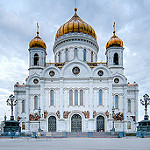

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Busan/4_DeepLearning/pic/torch3.png')
img

In [ ]:
# torch에서 컨트롤
import numpy as np

In [ ]:
type(img), np.array(img).shape, img.size
# 세로 150, 가로 150, 컬러수 3채널

(PIL.PngImagePlugin.PngImageFile, (150, 150, 3), (150, 150))

In [ ]:
# 컬러는 그레이 스케일로 변환 => 3채널을 1채널로 변환
# L = R * 299/1000 + G * 587/1000 + B * 114/1000
img = img.convert('L')
type(img), np.array(img).shape, img.size
# 채널이 1로 줄어들면서 dimension도 축소가 되었다.

(PIL.Image.Image, (150, 150), (150, 150))

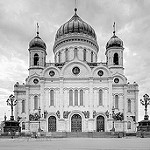

In [ ]:
img

# 파이토치를 이용한 CNN의 핵심 기능 구현

## 이미지 => 배열 => 텐서

In [ ]:
img_tensor = torch.Tensor(np.array(img))
img_tensor.size()
# reshape(view)나 unsqueeze로 변환 가능하다.
# [-1, 150, 150, 1] or [-1, 1, 150, 150]로 변환해야 한다.

torch.Size([150, 150])

In [ ]:
# 수직 커널 준비(수직값을 추출할 수 있는 W를 가진다. => 수직 커널)
# 3x3
kernel = torch.Tensor( [ [1,0,-1],[1,0,-1],[1,0,-1] ] )
kernel

tensor([[ 1.,  0., -1.],
        [ 1.,  0., -1.],
        [ 1.,  0., -1.]])

In [ ]:
# 합성곱층에서 xW 수행을 고려해 x는 img_tensor, W는 kernel을 이용하여 계산
# 실제로 API도 존재함(합성곱층을 생성하는)
# 1. 이미지의 세로, 가로 크기
height, width = img_tensor.size()
height, width

(150, 150)

In [ ]:
# 커널의 크기를 차원별로 구하고 싶다.
kernel.size(), kernel.size(0), kernel.size(1)

(torch.Size([3, 3]), 3, 3)

In [ ]:
# 이동량(strides) : 일단 1로 고정
stride = 1

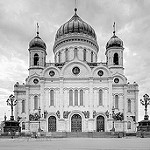

In [ ]:
img
# 이미지의 좌표계는 4사분면(좌측 상단이 (0,0))

## 합성곱층 직접 구현


- 일부 기능 생략, 고정
- img_tensor의 왼쪽 상단부터 커널을 이동시키면서 해당 커널이 원본 이미지에 겹치는 구간에서 xW 연산을 진행시켜서 모아둔다(순서대로).

In [ ]:
# x : 입력 데이터, 텐서
# kernel : 가중치 W를 공용 파라미터(매개변수)로 가지고 있는 커널, 텐서
def convolution_func(x, kernel, stride=1) :
  # 이미지의 세로, 가로 크기
  x_height, x_width = x.size()
  # 커널의 세로, 가로 크기
  k_height, k_width = kernel.size()

  # 높이의 경계는 현재 기준에서는 이미지 높이 - 커널 높이 + 1(보정, stride가 1일 때 해당됨)
  convs = list()
  # stride가 2 이상인 경우에 대한 대비는 현재 미적용(stride가 1일 때만 사용할 수 있는 함수다.)
  for i in range(0, x_height-k_height+1, stride) :    # 세로로 이동
    # 가로 한 줄에 대한 필터와 이미지 원본 간의 계산 결과를 담는 그릇
    tmp = list()
    for j in range(0, x_width-k_width+1, stride) :    # 가로로 이동
      # 계산 => 커널 영역에 해당되는 이미지 원본과 커널 간의 계산
      # 커널 크기 3x3, 이미지 원본 중 커널과 겹치는 3x3과 계산
      # 행렬의 곱을 수행했다! => xW
      # sum(커널과 계산이 되는 이미지 원본 영역(tensor) 획득 * 커널(tensor))
      tmp.append(torch.sum( x[ i:(i+k_height), j:(j+k_width) ] * kernel ))
    # 한 줄 단위로 전체 리스트에 담는다.
    convs.append(tmp)
  return torch.Tensor(convs)

In [ ]:
vertical_convs = convolution_func(img_tensor, kernel)
vertical_convs

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])

In [ ]:
kernel.T

tensor([[ 1.,  1.,  1.],
        [ 0.,  0.,  0.],
        [-1., -1., -1.]])

In [ ]:
# 수평 커널 적용한
horizontal_convs = convolution_func(img_tensor, kernel.T)
horizontal_convs

tensor([[ -5.,  -4.,  -3.,  ...,   5.,   5.,   5.],
        [ 16.,  13.,   7.,  ...,   3.,   8.,  13.],
        [ 28.,  23.,  14.,  ...,   2.,   8.,  15.],
        ...,
        [-27., -30., -32.,  ...,  19.,  21.,  22.],
        [-42., -44., -46.,  ...,  -2.,   1.,   6.],
        [ 10.,  11.,  13.,  ...,  15.,  17.,  23.]])

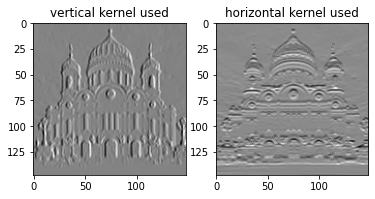

In [ ]:
# vertical_convs, horizontal_convs를 한 줄에 2칸으로 해서 그리시오.
# imshow(배열, cmap='binary')
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(vertical_convs.numpy(), cmap='binary')
ax1.set_title('vertical kernel used')

ax2.imshow(horizontal_convs.numpy(), cmap='binary')
ax2.set_title('horizontal kernel used')

plt.show()
# 커널의 결과에 의해서 이미지의 특성(외곽선 부분)이 잘 추출(도출)되었다.

In [ ]:
# 커널이 연산하는 과정에서 경계값쪽에서 padding이 valid로 적용된 결과다.
horizontal_convs.size()

torch.Size([148, 148])

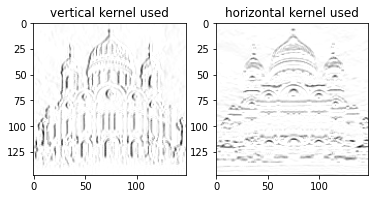

In [ ]:
# 데이터 전체적으로 음수 처리 -> 활성화 함수를 통과시킨다.
# 음수는 0으로, 양수는 그 값 그대로  -> Relu 적용
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(torch.relu(vertical_convs).numpy(), cmap='binary')
ax1.set_title('vertical kernel used')

ax2.imshow(torch.relu(horizontal_convs).numpy(), cmap='binary')
ax2.set_title('horizontal kernel used')

plt.show()
# 음수가 제거되면서 음수 자리는 모두 0이 되어 흰색으로 표현되었다.
# 경계선이 많이 도드라지게 보인다.

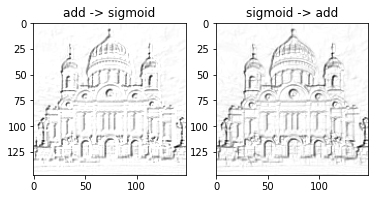

In [ ]:
# 2개의 데이터를 더해서 표현
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.imshow(torch.relu(vertical_convs + horizontal_convs).numpy(), cmap='binary')
ax1.set_title('add -> sigmoid')

ax2.imshow((torch.relu(vertical_convs) + torch.relu(horizontal_convs)).numpy(), cmap='binary')
ax2.set_title('sigmoid -> add')

plt.show()
# 수직 성분과 수평 성분을 필터링한 결과를 더해서 활성화를 통과시키니 결과가 더 좋게 나온다.
# 아이디어 : 수직 커널을 양방향 + 수평 커널을 양방향 => 합성(각각 2개씩, 총 4개의 텐서를 사용하면 더욱 좋지 않을까?)

In [ ]:
# 순수 CNN에서는 풀링층에서, 합성곱 통과한 결과에서 특징을 강화한다
# 1개의 데이터 중 최대값 표현
# 1개의 데이터 중 평균값 표현

## API를 이용하여 합성곱층 구현

In [ ]:
# 대체적으로 딥러닝의 주요 패키지는 nn 밑에 존재한다.
import torch.nn as nn

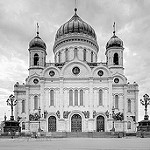

In [ ]:
img

In [ ]:
img_tensor, img_tensor.size()

(tensor([[212., 213., 215.,  ..., 197., 199., 200.],
         [215., 216., 216.,  ..., 197., 199., 200.],
         [214., 215., 216.,  ..., 196., 197., 198.],
         ...,
         [171., 171., 172.,  ..., 163., 166., 161.],
         [174., 174., 174.,  ..., 173., 175., 168.],
         [168., 168., 168.,  ..., 158., 159., 150.]]), torch.Size([150, 150]))

In [ ]:
# fmt : 포맷, (batch_size, in_channel, h, w) => channel_first(NCHW)
# [150, 150] -> (1, 1, h, w)
# dimension이 확장된다 => expand()(2D -> 4D)
# 더 큰 차원으로 확장할 때, expand()를 사용할 수 있다.
h,w        = img_tensor.size()
img_tensor = img_tensor.expand(1,1,h,w)
img_tensor.size()

torch.Size([1, 1, 150, 150])

In [ ]:
# 데이터의 shape 정보를 변수로 받아서 지정
batch, in_channels, height, width = img_tensor.size()

In [ ]:
# 기타 환경 변수(위에서 수동으로 만든 것과 같은 결과를 만들고 싶다.)
out_channels = 1
kernel_size  = 3    # 세로, 가로 크기가 동일하다
stride       = 1    # 세로, 가로 크기가 동일하다

In [ ]:
conv_layer = nn.Conv2d(
    in_channels = in_channels, 
    out_channels= out_channels, 
    kernel_size = kernel_size,
    stride      = stride,
    bias        = False
    )
# padding 옵션을 제외하고는 수동으로 만든 합성곱 코드와 유사하게 구성하였다.

In [ ]:
conv_layer, type(conv_layer)

(Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), bias=False),
 torch.nn.modules.conv.Conv2d)

In [ ]:
kernel, kernel.size()

(tensor([[ 1.,  0., -1.],
         [ 1.,  0., -1.],
         [ 1.,  0., -1.]]), torch.Size([3, 3]))

In [ ]:
# 커널을 (1,1,3,3)으로 확장한다.
tmp_kernel = kernel.expand(1,1,kernel.size(0),kernel.size(1))
tmp_kernel.size()

torch.Size([1, 1, 3, 3])

In [ ]:
# 커널 적용 => 합성곱층 객체에 커널을 등록
# 합성곱층을 만든 후에 가중치 값을 부여
conv_layer.weight.data = tmp_kernel
conv_layer.weight.data

tensor([[[[ 1.,  0., -1.],
          [ 1.,  0., -1.],
          [ 1.,  0., -1.]]]])

In [ ]:
# 합성곱층에 입력 x를 투입
convs = conv_layer(img_tensor)
convs.size()

torch.Size([1, 1, 148, 148])

- Tensor로 연산을 하게 되면 모든 과정이 기록되고, 역전파를 통한 최적화 수행 시 내부적으로는 미분을 통해서 y -> x로 가게 된다. 텐서 연산을 수행하면 내부적으로 미분 계산이 진행된다.
- 해당 패키지는 autogrid라는 패키지가 담당하게 된다.
- define by run : 실행 기반 정의에 포함된 패키지
- 해당 미분 계산 과정을 일식적으로 중단시키고, 현재까지 학습된 모델을 테스트하거나, 지금처럼 그림을 그리기 위해서 데이터를 추출하거나 할 경우, 미분 계산을 중단하라는 명령을 사용해야 한다 
  - detach() 함수를 사용

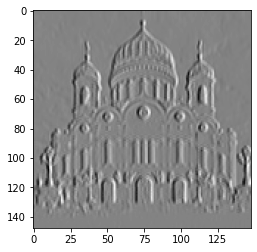

In [ ]:
# convs를 시각화하시오
plt.imshow(convs.squeeze().detach().numpy(), cmap='binary')
plt.show()

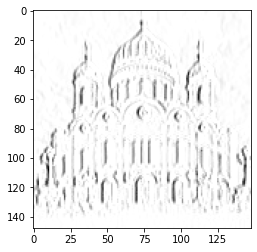

In [ ]:
plt.imshow(torch.relu(convs.squeeze()).detach().numpy(), cmap='binary')
plt.show()

In [ ]:
print(convs.squeeze())
print(vertical_convs)
# 둘이 동일한 것으로 보인다.

tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]],
       grad_fn=<SqueezeBackward0>)
tensor([[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
        [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
        [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
        ...,
        [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
        [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
        [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]])


# 합성곱에서 사용하는 W,s,p 등의 관계식

- 요소
  - P : padding
  - K : kernel의 크기
  - S : stride, 이동량
  - 커널이 통과되고 나서 이미지의 크기
    - h, w : 대상이 되는 원본 이미지의 높이, 너비
    - H = ( ( h + 2*P - K ) / S ) + 1
      - ( ( 150 + 2*0 - 3 ) / 1 ) + 1 = 148
    - W = ( ( w + 2*P - K ) / S ) + 1
      - ( ( 150 + 2*0 - 3 ) / 1 ) + 1 = 148

In [ ]:
# 활성화맵을 산출물로 정의
# convs : 여기까지 결과물은 feature map
activation_map = torch.relu(convs)

# 풀링 구현

- 여기에 들어오는 입력 데이터의 특징을 강화
- 최대풀링, 평균풀링 등

In [ ]:
activation_map

tensor([[[[ 0.,  0.,  3.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  1.],
          ...,
          [ 0.,  1.,  2.,  ...,  2.,  0.,  5.],
          [ 0.,  0.,  0.,  ...,  4.,  2.,  8.],
          [ 0.,  0.,  0.,  ...,  4.,  6., 15.]]]], grad_fn=<ReluBackward0>)

In [ ]:
activation_map.size()

torch.Size([1, 1, 148, 148])

In [ ]:
# 커널 사이즈
kernel_size = 2
# 이동량
stride_size = 2

In [ ]:
# 구현 1 : for문을 이용하여 대상을 특정하고 max 처리
# 구현 2 : 해당 대상을 잘 특정하여(shape의 조작) max값을 구하는 방법 => unfold 함수 사용

In [ ]:
convs

tensor([[[[ -6.,  -3.,   3.,  ...,  -8., -10.,  -8.],
          [ -6.,  -4.,  -1.,  ...,  -7.,  -7.,  -4.],
          [ -9., -10.,  -8.,  ...,  -3.,  -1.,   1.],
          ...,
          [  0.,   1.,   2.,  ...,   2.,  -1.,   5.],
          [ -1.,  -1.,   0.,  ...,   4.,   2.,   8.],
          [ -1.,  -2.,   0.,  ...,   4.,   6.,  15.]]]],
       grad_fn=<MkldnnConvolutionBackward>)

In [ ]:
# ( 대상 dimesion, kernel_size 대상의 범위(2개씩 묶는다), 대상을 특정할 때 이동하는 양 )
tmp = convs.unfold(2, kernel_size, stride_size).unfold(3, kernel_size, stride_size)
# 커널이 연산의 대상으로 타겟하는 효과를 간편하게 구성할 수 있다.
tmp, tmp.size()
# [1, 1, 74, 74, 2, 2]

(tensor([[[[[[ -6.,  -3.],
             [ -6.,  -4.]],
 
            [[  3.,   3.],
             [ -1.,   0.]],
 
            [[ -2.,  -4.],
             [ -1.,  -3.]],
 
            ...,
 
            [[-29., -28.],
             [-28., -23.]],
 
            [[ -2.,  -8.],
             [ -2.,  -7.]],
 
            [[-10.,  -8.],
             [ -7.,  -4.]]],
 
 
           [[[ -9., -10.],
             [-10., -15.]],
 
            [[ -8.,  -7.],
             [-16., -13.]],
 
            [[ -4.,  -2.],
             [ -7.,  -3.]],
 
            ...,
 
            [[-29., -22.],
             [-24., -19.]],
 
            [[ -1.,  -3.],
             [ -2.,   0.]],
 
            [[ -1.,   1.],
             [  4.,   5.]]],
 
 
           [[[-10., -17.],
             [ -9., -17.]],
 
            [[-19., -15.],
             [-20., -15.]],
 
            [[ -8.,  -2.],
             [ -7.,   0.]],
 
            ...,
 
            [[-15., -13.],
             [ -6., -10.]],
 
            [[ -4.,   0.]

In [ ]:
# max()[0]을 취해야 텐서가 나온다.
# [0] => 인덱싱을 취해야 텐서가 나온다.
# (1,1,74,148,2) -> max -> (1,1,74,148)
print(convs.unfold(2, kernel_size, stride_size).max(-1))
print("----------------------------------------------------------------")
print(convs.unfold(2, kernel_size, stride_size).max(-1)[0])
print(convs.unfold(2, kernel_size, stride_size).max(-1)[0].size())

torch.return_types.max(
values=tensor([[[[ -6.,  -3.,   3.,  ...,  -7.,  -7.,  -4.],
          [ -9., -10.,  -8.,  ...,   0.,   4.,   5.],
          [ -9., -17., -19.,  ...,   0.,   5.,   6.],
          ...,
          [ -4.,   5.,   1.,  ...,   4.,   2.,   5.],
          [  2.,   3.,   2.,  ...,   2.,  -1.,   6.],
          [ -1.,  -1.,   0.,  ...,   4.,   6.,  15.]]]],
       grad_fn=<MaxBackward0>),
indices=tensor([[[[0, 0, 0,  ..., 1, 1, 1],
          [0, 0, 0,  ..., 1, 1, 1],
          [1, 0, 0,  ..., 0, 0, 0],
          ...,
          [1, 1, 1,  ..., 1, 0, 1],
          [0, 0, 1,  ..., 0, 1, 0],
          [0, 0, 0,  ..., 0, 1, 1]]]]))
----------------------------------------------------------------
tensor([[[[ -6.,  -3.,   3.,  ...,  -7.,  -7.,  -4.],
          [ -9., -10.,  -8.,  ...,   0.,   4.,   5.],
          [ -9., -17., -19.,  ...,   0.,   5.,   6.],
          ...,
          [ -4.,   5.,   1.,  ...,   4.,   2.,   5.],
          [  2.,   3.,   2.,  ...,   2.,  -1.,   6.],
  

In [ ]:
# 커널의 대상이 될 때까지 unfold를 수행하고, 해당 값들로부터 최대값을 가로/세로로 구해서, 차원을 다시 4-D로 줄여나가서 결과를 얻는다.
# max(dimension), 최대값이 적용되는 dimension은 정해져있다. 
# 일일이 체크해서 지정할 것인가 or 심플하게 -1로 할 것인가(나는 모르겠으니 알아서 해라 -> C++이 알아서 특정 dim에 가서 max 적용) 
tmp = convs.unfold(2, kernel_size, stride_size).unfold(3, kernel_size, stride_size).max(-1)[0].max(-1)[0]
tmp, tmp.size()

(tensor([[[[ -3.,   3.,  -1.,  ..., -23.,  -2.,  -4.],
           [ -9.,  -7.,  -2.,  ..., -19.,   0.,   5.],
           [ -9., -15.,   0.,  ...,  -6.,   0.,   6.],
           ...,
           [  5.,   1.,  11.,  ...,  12.,   4.,   5.],
           [  3.,   2.,   0.,  ...,  10.,   2.,   6.],
           [ -1.,   0.,   0.,  ...,  10.,   4.,  15.]]]],
        grad_fn=<MaxBackward0>), torch.Size([1, 1, 74, 74]))

In [ ]:
# 최대 풀링 처리 함수
def maxPooling( x, kernel_size, stride = None ) :
  # stride가 None이면 kernel_size와 동사이즈
  if not stride :
    stride = kernel_size
  maxPool = x.unfold(2, kernel_size, stride_size).unfold(3, kernel_size, stride_size).max(-1)[0].max(-1)[0]
  return maxPool

In [ ]:
tmp = torch.arange(0, 16).reshape(1,1,4,4)
tmp

tensor([[[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7],
          [ 8,  9, 10, 11],
          [12, 13, 14, 15]]]])

In [ ]:
tmp.unfold(2,2,2), tmp.unfold(2,2,2).size()

(tensor([[[[[ 0,  4],
            [ 1,  5],
            [ 2,  6],
            [ 3,  7]],
 
           [[ 8, 12],
            [ 9, 13],
            [10, 14],
            [11, 15]]]]]), torch.Size([1, 1, 2, 4, 2]))

In [ ]:
tmp.unfold(2,2,2).unfold(3,2,2), tmp.unfold(2,2,2).unfold(3,2,2).size()

(tensor([[[[[[ 0,  1],
             [ 4,  5]],
 
            [[ 2,  3],
             [ 6,  7]]],
 
 
           [[[ 8,  9],
             [12, 13]],
 
            [[10, 11],
             [14, 15]]]]]]), torch.Size([1, 1, 2, 2, 2, 2]))

In [ ]:
# 순수 CNN에서는 풀링층에서, 합성곱 통과한 결과에서 특징을 강화한다
# 1개의 데이터 중 최대값 표현
# 1개의 데이터 중 평균값 표현

In [ ]:
# 풀링
maxPool_map = maxPooling(activation_map, kernel_size)
maxPool_map, maxPool_map.size()

(tensor([[[[ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  5.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  6.],
           ...,
           [ 5.,  1., 11.,  ..., 12.,  4.,  5.],
           [ 3.,  2.,  0.,  ..., 10.,  2.,  6.],
           [ 0.,  0.,  0.,  ..., 10.,  4., 15.]]]], grad_fn=<MaxBackward0>),
 torch.Size([1, 1, 74, 74]))

In [ ]:
# API
maxPool_layer = nn.MaxPool2d(kernel_size=kernel_size, stride=stride_size)
maxPool_layer

MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

In [ ]:
pooling_map = maxPool_layer(activation_map)
pooling_map, pooling_map.shape
# maxPool_map과 pooling_map이 동일한 것으로 보인다.

(tensor([[[[ 0.,  3.,  0.,  ...,  0.,  0.,  0.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  5.],
           [ 0.,  0.,  0.,  ...,  0.,  0.,  6.],
           ...,
           [ 5.,  1., 11.,  ..., 12.,  4.,  5.],
           [ 3.,  2.,  0.,  ..., 10.,  2.,  6.],
           [ 0.,  0.,  0.,  ..., 10.,  4., 15.]]]],
        grad_fn=<MaxPool2DWithIndicesBackward>), torch.Size([1, 1, 74, 74]))

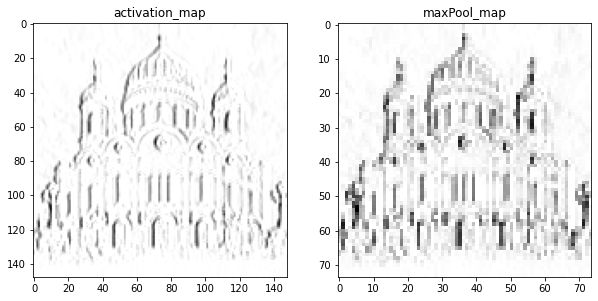

In [ ]:
# 시각화를 통해서 특성이 강화된 데이터를 확인해보겠다.
# 풀링 통과 전, 풀링 통과 후 이미지 2개를 출력
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 풀링층 통과 전 이미지
ax1.imshow(activation_map.squeeze().detach().numpy(), cmap='binary')
ax1.set_title('activation_map')
# 풀링층 통과 후 이미지
ax2.imshow(maxPool_map.squeeze().detach().numpy(), cmap='binary')
ax2.set_title('maxPool_map')

plt.show()
# 경계선 쪽에 윤곽이 더 도드라진 것을 확인할 수 있다.